In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from interpretable_models import GradCAM

In [0]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.ndimage.interpolation import zoom
from mpl_toolkits.axes_grid1 import ImageGrid
import json
import numpy as np
import glob

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

### Reading class labels from VGG16

In [5]:
!wget "https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json"
CLASS_INDEX = json.load(open("imagenet_class_index.json"))
classlabel  = []
for i_dict in range(len(CLASS_INDEX)):
    classlabel.append(CLASS_INDEX[str(i_dict)][1])
print("N of class={}".format(len(classlabel)))

--2020-05-12 00:25:38--  https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [text/plain]
Saving to: ‘imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0s      

2020-05-12 00:25:39 (85.0 MB/s) - ‘imagenet_class_index.json’ saved [35363/35363]

N of class=1000


### Loading VGG16 model

In [6]:
model_vgg6 = VGG16(weights='imagenet')

553467904/553467096 [==============================] - 6s 0us/step


In [7]:
for ilayer, layer in enumerate(model_vgg6.layers):
    print("{:3.0f} {:10}".format(ilayer, layer.name))

  0 input_1   
  1 block1_conv1
  2 block1_conv2
  3 block1_pool
  4 block2_conv1
  5 block2_conv2
  6 block2_pool
  7 block3_conv1
  8 block3_conv2
  9 block3_conv3
 10 block3_pool
 11 block4_conv1
 12 block4_conv2
 13 block4_conv3
 14 block4_pool
 15 block5_conv1
 16 block5_conv2
 17 block5_conv3
 18 block5_pool
 19 flatten   
 20 fc1       
 21 fc2       
 22 predictions


In [0]:
def ajust_heatmap(img, Lcam):

  dim = Lcam.shape
  ## upsampling the class activation map to th esize of ht input image
  scale_factor        = np.array(img.shape[:-1])/np.array(Lcam.shape)

  _grad_CAM           = zoom(Lcam,scale_factor)
  ## normalize to range between 0 and 1
  arr_min, arr_max    = np.min(_grad_CAM), np.max(_grad_CAM)
  grad_CAM            = (_grad_CAM - arr_min) / (arr_max - arr_min + 1e-10)


  cm = plt.get_cmap('jet')
  colored_image = cm(grad_CAM)
  colored_image = colored_image[:,:,0:3]
  colored_image = colored_image/np.max(colored_image)

  return colored_image

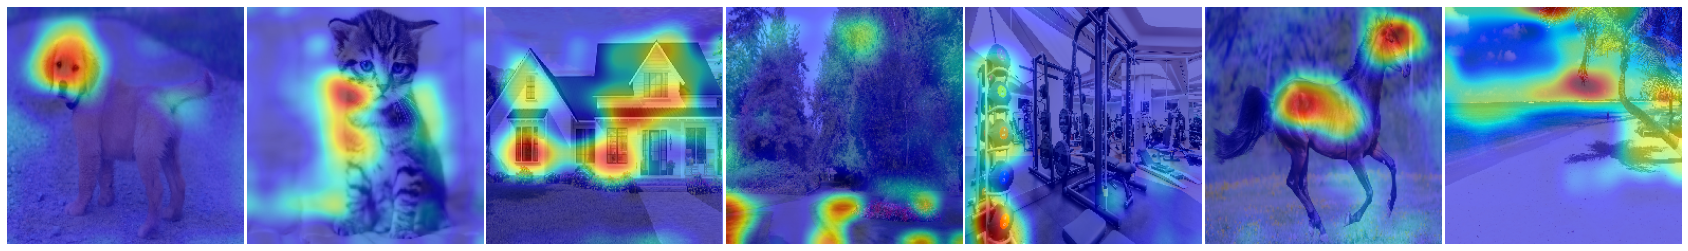

In [12]:
path_images = "/content/drive/My Drive/Interpretability/images/*"
imgs = glob.glob(path_images)


fig = plt.figure(figsize=(30,30))
#from https://matplotlib.org/2.0.2/mpl_toolkits/axes_grid/users/overview.html
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 7),  # creates 2x2 grid of axes
                 axes_pad=0.04,  # pad between axes in inch.
                 )
font = {'family': 'serif',
        'size': 12,
        }

i = 0
for p in imgs:
  ax = grid[i]
  img = load_img(p,target_size=(224,224))
  ax.imshow(img)


  img = img_to_array(img)
  img = preprocess_input(img)
  y_pred = model_vgg6.predict(img[np.newaxis,...])
  index = np.argmax(y_pred, axis=1)

  gradCam = GradCAM(model_vgg6.inputs, model_vgg6.layers[17].output, model_vgg6.layers[22].output)
  Lcam, convOutputs, grads = gradCam.computeLGRAD_CAM(classIdx = index[0], inputs = img[np.newaxis,...])
  heatmap = ajust_heatmap(img_to_array(img), Lcam)

  ax.imshow(heatmap, alpha=0.55)
  #ax.text(10, 10, classlabel[index[0]],  fontdict=font, color='b', backgroundcolor='w', alpha=0.8)

  ax.axis('off')
  i = i+1
plt.show()

